In [1]:
import os
import sys
import numpy as np
import matplotlib
matplotlib.use('nbagg')
#from matplotlib import style
#style.use('ggplot')
import matplotlib.pyplot as plt

from skimage import feature
from scipy import stats, ndimage

import photutils

from astropy import units as u
from astropy import stats
from astropy import visualization
from astropy.table import Table, vstack
from astropy.io import ascii, fits
from astropy.modeling import models, fitting, custom_model

In [2]:
def mk_pupil_model(size=400):
    """
    Use photutils to make an annular mask to use as a model for what a pupil should look like. 
    
    Returns
    -------
    mask:  2D np.ndarray
        Mask containing annular pupil model
    """
    annulus = np.zeros((size, size))
    # this mask will be 1 inside the annulus, 0 outside, and interpolated in pixels that are partially overlapped
    outer = photutils.geometry.circular_overlap_grid(-size/2., size/2., -size/2., size/2., size, size, 180, use_exact=0, subpixels=5)
    inner = photutils.geometry.circular_overlap_grid(-size/2., size/2., -size/2., size/2., size, size, 40, use_exact=0, subpixels=5)
    mask = annulus + outer - inner
    return mask

def plot_wfsfind(data, sources, ap_radius=5.0):
    positions = (sources['xcentroid'], sources['ycentroid'])
    apertures = photutils.CircularAperture(positions, r=ap_radius)
    norm = visualization.mpl_normalize.ImageNormalize(stretch=visualization.SqrtStretch())
    plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='None')
    apertures.plot(color='red', lw=1.5, alpha=0.5)

def wfsfind(data, fwhm=5.0, threshold=7.0, plot=False):
    if isinstance(data, str):
        # we're a fits file (hopefully)
        data = fits.open(data)[0].data
    mean, median, std = stats.sigma_clipped_stats(data, sigma=3.0, iters=5)
    daofind = photutils.DAOStarFinder(fwhm=fwhm, threshold=threshold*std)
    sources = daofind(data - median)
    if plot:
        plot_wfsfind(data, sources)
    return sources

def mk_reference(data, plot=True):
    if isinstance(data, str):
        # we're a fits file (hopefully)
        data = fits.open(data)[0].data
    spots = wfsfind(data, fwhm=4.0, threshold=30.0, plot=plot)
    xcen = spots['xcentroid'].mean()
    ycen = spots['ycentroid'].mean()
    
    # just using the mean will be offset from the true center due to missing spots at edges.
    # find the spot closest to the mean and make it the center position of the pattern.
    dist = ((spots['xcentroid'] - xcen)**2 + (spots['ycentroid'] - ycen)**2)
    closest = np.argmin(dist)
    xoff = spots['xcentroid'][closest] - xcen
    yoff = spots['ycentroid'][closest] - ycen
    xcen += xoff
    ycen += yoff
    plt.scatter(xcen, ycen)
    return spots

def center_pupil(data):
    if isinstance(data, str):
        # we're a fits file (hopefully)
        data = fits.open(data)[0].data
    # use skimage.feature.match_template() to do a fast cross-correlation between the WFS image and the pupil model.
    # the location of the peak of the correlation will be the center of the WFS pattern.
    mask = mk_pupil_model()
    match = feature.match_template(data, mask, pad_input=True)
    match[match < 0.9*match.max()] = 0
    cen = photutils.centroids.centroid_com(match)
    return cen

<IPython.core.display.Javascript object>


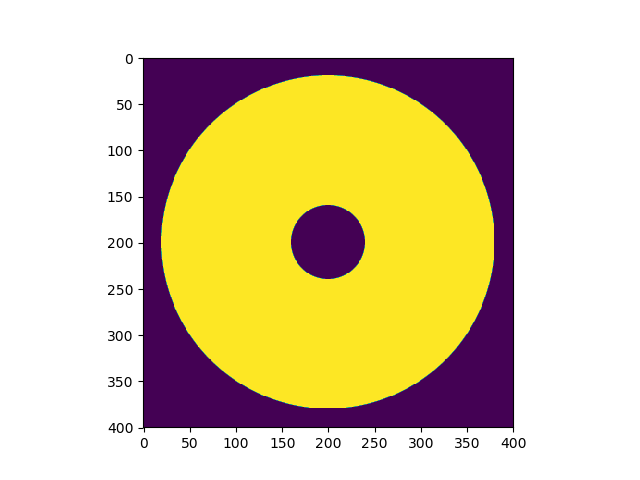

In [3]:
mask = mk_pupil_model()
plt.imshow(mask)
plt.show()

In [4]:
file = "/Users/tim/MMT/wfsdat/20170110/rawdata/mmirs_wfs_0373.fits"
center = ascii.read("/Users/tim/MMT/shwfs/mmirs2_reference.center")
ref = ascii.read("/Users/tim/MMT/shwfs/mmirs2_sysfile.cntr")
ref1_fits = "/Users/tim/MMT/mmtwfs/ref_images/mmirs_camera1_ref.fits"
ref2_fits = "/Users/tim/MMT/mmtwfs/ref_images/mmirs_camera2_ref.fits"
# test images from 20170110: 1, 7, 44, 61, 126, 131-138, 161-168, 183-189, 194-198, 298-299, 327, 369-372
test_fits = "/Users/tim/MMT/wfsdat/20170110/rawdata/mmirs_wfs_0168.fits"

im = fits.open(file)[0].data
ref1_im = fits.open(ref1_fits)[0].data
ref2_im = fits.open(ref2_fits)[0].data
test = fits.open(test_fits)[0].data

<IPython.core.display.Javascript object>


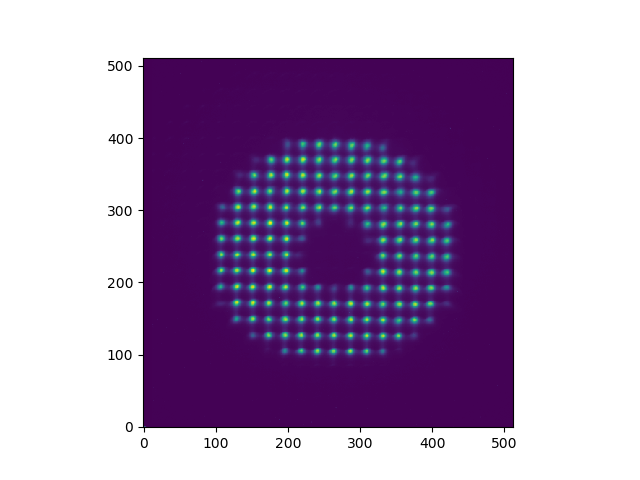

In [5]:
plt.imshow(test, interpolation='nearest', origin='lower')
#plt.scatter(ref['col1'], ref['col2'], color='purple')
#plt.scatter(center['col1'], center['col2'], marker='x', color='white')
#plt.scatter(271, 229, marker='x', color='white')
plt.show()

<IPython.core.display.Javascript object>


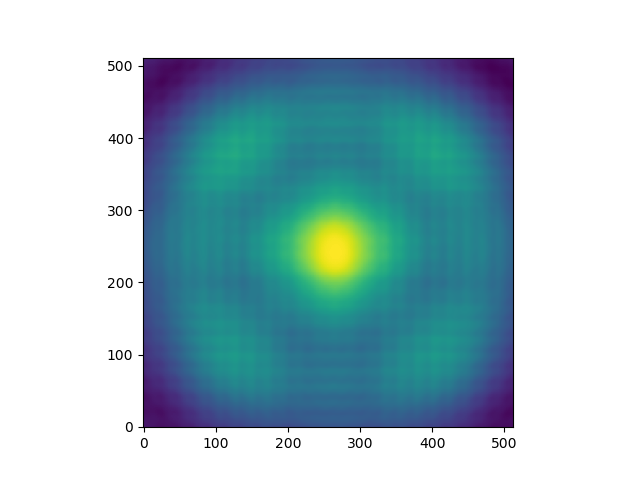

In [6]:
# use skimage.feature.match_template() to do a fast cross-correlation between the WFS image and the pupil model.
# the location of the peak of the correlation will be the center of the WFS pattern.
result = feature.match_template(test, mask, pad_input=True)
plt.imshow(result, interpolation='nearest', origin='lower')
plt.show()

<IPython.core.display.Javascript object>


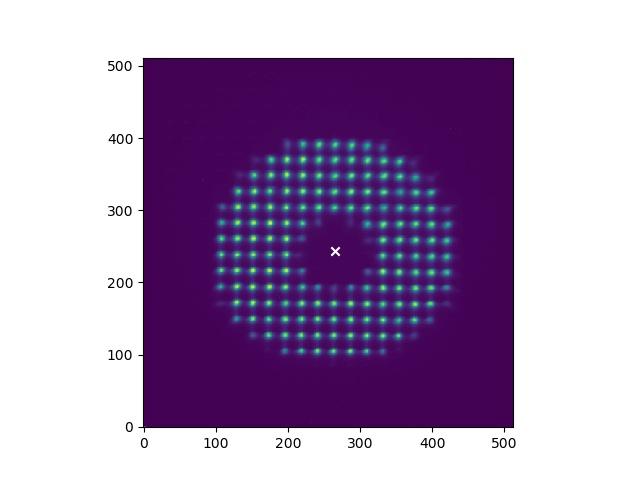

In [7]:
# the correlation image is somewhat complicated, but the peak is distinct as long as there are detectable WFS spots.
# clip the image at 90% of the peak and then do a center-of-mass centroid on it. 
plt.imshow(test, interpolation='nearest', origin='lower')
result[result < 0.9*result.max()] = 0
cen = photutils.centroids.centroid_com(result)
plt.scatter(cen[0], cen[1], marker='x', color='white')
plt.show()

In [8]:
# ndimage and photutils should give the same answer for CoM centroids...
ndimage.center_of_mass(result)

(244.10445659511728, 264.98077038766058)

<IPython.core.display.Javascript object>


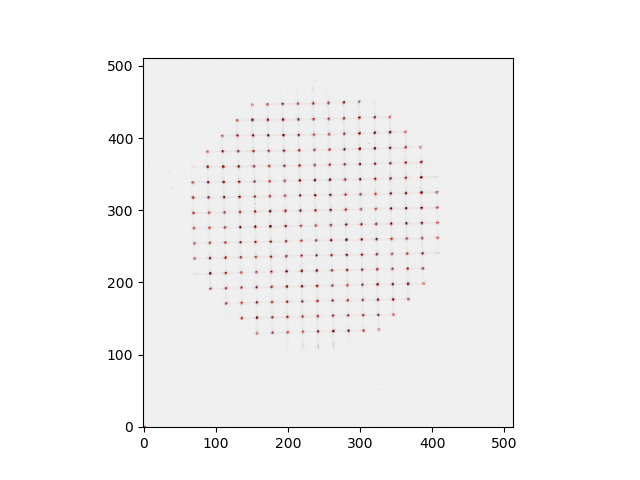

In [9]:
ref_file = "/Users/tim/MMT/mmtwfs/ref_images/mmirs_camera1_ref.fits"
ref_data = fits.open(ref_file)[0].data
mean, median, std = stats.sigma_clipped_stats(ref_data, sigma=3.0, iters=5)

daofind = photutils.DAOStarFinder(fwhm=4, threshold=30.0*std)
#starfind = photutils.IRAFStarFinder(fwhm=2.0, threshold=5.0*std)

dao_sources = daofind(ref_data - median)
#iraf_sources = starfind(ref_data - median)

plot_wfsfind(ref_data, dao_sources, ap_radius=0.5)
plt.show()

<IPython.core.display.Javascript object>


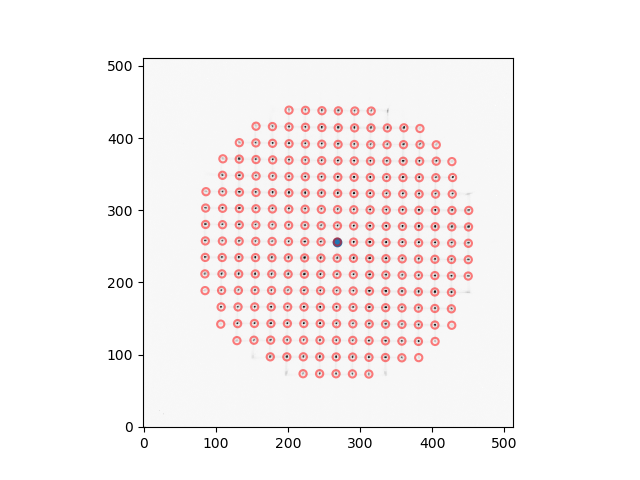

In [20]:
rs = mk_reference("/Users/tim/MMT/mmtwfs/ref_images/mmirs_camera2_ref.fits")
plt.show()

<IPython.core.display.Javascript object>


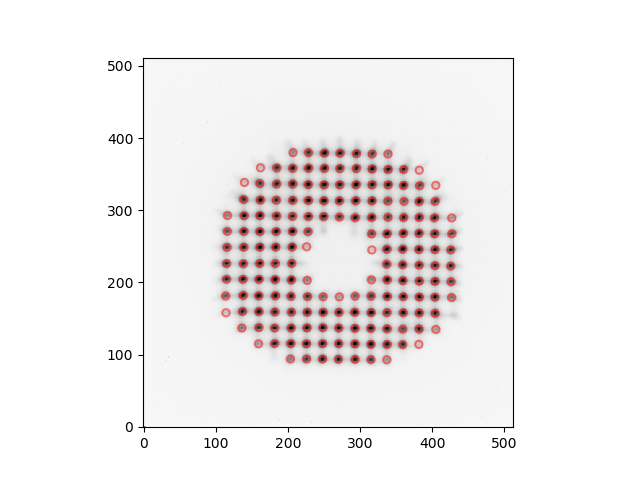

In [11]:
s = wfsfind("/Users/tim/MMT/wfsdat/20170110/rawdata/mmirs_wfs_0232.fits", fwhm=7.0, plot=True)
plt.show()

In [12]:
s['xcentroid'].mean()

270.40498984482582

In [13]:
rs

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,266.647025365,73.5191875315,0.544193819698,-0.118758196616,0.245698263942,25.0,0.0,15716.0,18.5708311956,-3.17207835596
2,289.325586664,73.3463512846,0.564210216674,0.296710580602,0.214170104539,25.0,0.0,15222.0,17.7401513017,-3.12239329878
3,312.090560175,73.1281950674,0.572563242924,0.25119416523,0.505395513946,25.0,0.0,10228.0,11.5142320358,-2.65308744286
4,220.98741065,73.5898437144,0.599026129868,0.711811353896,0.553372974946,25.0,0.0,10310.0,11.0117642571,-2.60464226331
5,243.88661996,73.5914793732,0.583585658672,0.515500415144,0.326156330604,25.0,0.0,16504.0,18.8587337569,-3.18878132322
6,312.251832179,96.2972840213,0.589815949756,0.25558590703,0.0869819178237,25.0,0.0,21459.0,24.9137359952,-3.49109714506
7,335.097068377,95.9962897178,0.589401480445,0.0658184754701,0.0520408189762,25.0,0.0,21915.0,25.8185736952,-3.52983061677
8,357.82637901,95.6328367404,0.572359808117,0.0673771588545,0.200166044198,25.0,0.0,15832.0,18.4014504908,-3.16213014385
9,381.179113284,95.8862994126,0.458909517107,-0.0497278003747,0.847423916573,25.0,0.0,1361.0,1.25597753997,-0.247454682986


In [14]:
t = np.arange(len(rs))
f = np.linspace(1.0, 50.0, 100)
p = stats.LombScargle(t, rs['xcentroid']).power(f)

<IPython.core.display.Javascript object>


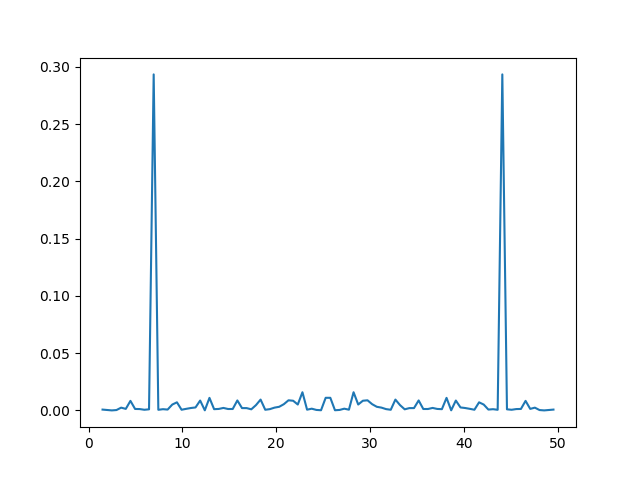

In [15]:
plt.plot(f, p)
plt.show()

In [16]:
edges = stats.bayesian_blocks(rs['xcentroid'], fitness='events')
edges

array([  84.98370597,   86.23510296,  107.21476016,  109.71189301,
        129.83016488,  132.79962268,  153.24131603,  155.84508314,
        175.78428597,  178.77605838,  198.66779493,  201.46793712,
        201.50699843,  221.15585493,  224.28154833,  244.00169697,
        247.04515344,  266.75073009,  269.74034415,  289.46094882,
        292.48942012,  312.17119618,  315.15565579,  335.11100006,
        337.4841396 ,  357.84841232,  360.37778125,  380.68146568,
        382.92352282,  403.49805779,  405.47645784,  426.44405413,
        427.8236754 ,  449.76460348,  450.45500904])

<IPython.core.display.Javascript object>


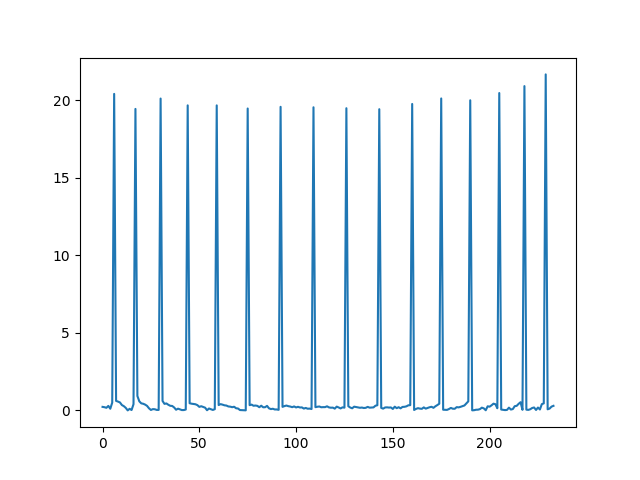

In [17]:
diffs = np.diff(sorted(rs['xcentroid']))
plt.plot(diffs)
plt.show()

In [18]:
stats.histogram(rs['xcentroid'], bins='blocks')

(array([ 6,  2,  9,  2, 11,  2, 12,  2, 13,  2, 11,  3,  2, 15,  2, 15,  2,
        15,  2, 15,  2, 15,  2, 13,  2, 13,  2, 13,  2, 11,  2,  9,  2,  4]),
 array([  84.98370597,   86.23510296,  107.21476016,  109.71189301,
         129.83016488,  132.79962268,  153.24131603,  155.84508314,
         175.78428597,  178.77605838,  198.66779493,  201.46793712,
         201.50699843,  221.15585493,  224.28154833,  244.00169697,
         247.04515344,  266.75073009,  269.74034415,  289.46094882,
         292.48942012,  312.17119618,  315.15565579,  335.11100006,
         337.4841396 ,  357.84841232,  360.37778125,  380.68146568,
         382.92352282,  403.49805779,  405.47645784,  426.44405413,
         427.8236754 ,  449.76460348,  450.45500904]))